In [1]:
# Load libraries

# # Plotting utils 
import datetime
import glob
import os
import pickle
import time
import warnings
from datetime import date, timedelta
import Ngl
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util
from cartopy.util import add_cyclic_point
import matplotlib as matplotlib
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import metpy.calc as mpc
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
from matplotlib.dates import DateFormatter
from metpy.units import units
from metpy import interpolate
from metpy.calc import vertical_velocity
from mpl_toolkits.axes_grid1 import make_axes_locatable

warnings.filterwarnings('ignore')


In [2]:
# - - - - - - - - - - - - - - - 
# Pre-process data while reading in 
# - - - - - - - - - - - - - - - 

def preprocess_h0(ds):
    
    keepVars_noGust = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
                    'U10','CLDHGH','CLDLIQ','TMQ',
                    'PHIS','CDNUMC','CLDLOW',
                    'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
                    'T','Q','OMEGA','PBLH','U','V','Z3',
                    'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC', 'ICEFRAC',
                    'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY',
                    'hyam','hybm','hyai','hybi']
    keepVars_gust = ['SWCF','LWCF','TS','CLOUD','FSNS','FLNS','PS',
                    'U10', 'UGUST','CLDHGH','CLDLIQ','TMQ',
                    'PHIS','CDNUMC','CLDLOW',
                    'CLDMED','CLDTOT','RVMTEND_CLUBB','STEND_CLUBB',
                    'T','Q','OMEGA','PBLH','U','V','Z3',
                    'PRECT','PRECC','PRECL','LANDFRAC','OCNFRAC','ICEFRAC',
                    'TGCLDLWP','LHFLX','SHFLX','TREFHT', 'TAUX','TAUY', 
                    'hyam','hybm','hyai','hybi']        
        
    ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    varnames = list(ds.keys())

    if 'UGUST' in varnames: 
        dsSel      = ds[keepVars_gust]
    else: 
        dsSel      = ds[keepVars_noGust]
        #dsSel['UGUST'] = (('time','lat','lon'), np.full([len(dsSel.time.values), len(dsSel.lat.values), len(dsSel.lon.values)], 0))
    
    return dsSel


def preprocess_h2(ds):
       
    keepVars = ['PRECC','PRECT','U850']
        
    ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex() 
    dsSel      = ds[keepVars]

    
    return dsSel



def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

def wgt_rmse(fld1, fld2, wgt):
    """Calculate the area-weighted RMSE.

    Parameters
    ----------
    fld1, fld2 : array-like
        2-dimensional spatial fields with the same shape.
        They can be xarray DataArray or numpy arrays.
    wgt : array-like
        the weight vector, expected to be 1-dimensional,
        matching length of one dimension of the data.

    Returns
    -------
    float
        root mean squared error

    Notes:
    ```rmse = sqrt( mean( (fld1 - fld2)**2 ) )```
    """
    assert len(fld1.shape) == 2,     "Input fields must have exactly two dimensions."
    assert fld1.shape == fld2.shape, "Input fields must have the same array shape."
    # in case these fields are in dask arrays, compute them now.
    if hasattr(fld1, "compute"):
        fld1 = fld1.compute()
    if hasattr(fld2, "compute"):
        fld2 = fld2.compute()
    if isinstance(fld1, xr.DataArray) and isinstance(fld2, xr.DataArray):
        return (np.sqrt(((fld1 - fld2)**2).weighted(wgt).mean())).values.item()
    else:
        check = [len(wgt) == s for s in fld1.shape]
        if ~np.any(check):
            raise IOError(f"Sorry, weight array has shape {wgt.shape} which is not compatible with data of shape {fld1.shape}")
        check = [len(wgt) != s for s in fld1.shape]
        dimsize = fld1.shape[np.argwhere(check).item()]  # want to get the dimension length for the dim that does not match the size of wgt
        warray = np.tile(wgt, (dimsize, 1)).transpose()   # May need more logic to ensure shape is correct.
        warray = warray / np.sum(warray) # normalize
        wmse = np.sum(warray * (fld1 - fld2)**2)
    
        return np.sqrt( wmse ).item()


In [3]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

## Dask?

In [4]:
import dask
dask.config.set({'logging.distributed': 'error'})


In [5]:
from dask_jobqueue import PBSCluster

# For Casper
cluster = PBSCluster(
    queue="casper",
    walltime="01:30:00",
    project="P93300642",
    memory="4GB",
    resource_spec="select=1:ncpus=1:mem=4GB",
    cores=1,
    processes=1,
)


In [6]:
from dask.distributed import Client

# Connect client to the remote dask workers
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/Extra/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/Extra/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.111:33653,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mdfowler/Extra/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [7]:
cluster.scale(24)

client.wait_for_workers(24)


## Read in data and do some processing

In [5]:
# testDir     = '/glade/derecho/scratch/hannay/archive/'

# case_IDs  = [
#                # 'BLT1850_054ctrl',
#                # 'BLT1850_064gust',    
#                'BLT1850_078b_oldGust',
#                'BLT1850_082b_1xGust',   
#                'BLT1850_081b_3xGust',   
#                'BLT1850_083b_0xGust',   

#               ]

# caseNames = [
#             'b.e23_alpha16g.BLT1850.ne30_t232.078b', 
#             'b.e23_alpha16g.BLT1850.ne30_t232.082b',
#             'b.e23_alpha16g.BLT1850.ne30_t232.081b',
#             'b.e23_alpha16g.BLT1850.ne30_t232.083b']

In [8]:
%%time 
testDir     = ['/glade/campaign/cgd/tss/people/mdfowler/GustProject/GustFix/', 
               '/glade/campaign/cgd/tss/people/mdfowler/GustProject/GustFix/',
               '/glade/campaign/cgd/tss/people/mdfowler/GustProject/GustFix/',
               # '/glade/campaign/cgd/tss/people/mdfowler/GustProject/GustFix/',
              ]

case_IDs  = [
               'CTRL_083b',
               'GUSTx1_082b',    
               'GUSTx3_081b',    
               # 'GUSTold_078b',    
              ]

caseNames = [
             'b.e23_alpha16g.BLT1850.ne30_t232.083b',
             'b.e23_alpha16g.BLT1850.ne30_t232.082b',
             'b.e23_alpha16g.BLT1850.ne30_t232.081b',
             # 'b.e23_alpha16g.BLT1850.ne30_t232.078b',

]

for iCase in range(len(case_IDs)):
    print('*** Starting on case %s ***' % (case_IDs[iCase]))

    ## Get list of files 
    listFiles_h0 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h0.00??-*'))
    listFiles_h1 = np.sort(glob.glob(testDir[iCase]+caseNames[iCase]+'/atm/hist/*cam.h2.00??-*'))
    
    ## Now read in those files
    case_h0 = xr.open_mfdataset(listFiles_h0,  preprocess=preprocess_h0, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h0 files loaded')
    
    case_h1 = xr.open_mfdataset(listFiles_h1,  preprocess=preprocess_h2, concat_dim='time', 
                                combine='nested', decode_times=True, 
                                data_vars='minimal', parallel=True)
    print('h1 files loaded')
        
    ## Add case ID (short name) to the DS
    case_h0      = case_h0.squeeze().assign_coords({"case":  case_IDs[iCase]})
    case_h1      = case_h1.squeeze().assign_coords({"case":  case_IDs[iCase]})

    # print('Year range: ', case_h0.time.dt.year.values[0], '-', case_h0.time.dt.year.values[-1])
    #    Output: 1-12, 1-12, 1-11, 1-11 
    
    ## Return all the cases in a single dataset  
    if iCase==0:
        h0_drchFix = case_h0
        h1_drchFix = case_h1
    else: 
        h0_drchFix = xr.concat([h0_drchFix, case_h0], "case") 
        h1_drchFix = xr.concat([h1_drchFix, case_h1], "case") 


*** Starting on case CTRL_083b ***
h0 files loaded
h1 files loaded
*** Starting on case GUSTx1_082b ***
h0 files loaded
h1 files loaded
*** Starting on case GUSTx3_081b ***
h0 files loaded
h1 files loaded
CPU times: user 4min 52s, sys: 10.6 s, total: 5min 3s
Wall time: 14min 11s


In [18]:
iTime = np.where((h0_drchFix['time.year'].values == 31) & 
                 (h0_drchFix['time.month'].values == 12) )[0]
print(h0_drchFix.isel(case=0, time=iTime).sel(lat=20,lon=180, method='nearest').LHFLX.values)
print(h0_drchFix.isel(case=1, time=iTime).sel(lat=20,lon=180, method='nearest').LHFLX.values)
print(h0_drchFix.isel(case=2, time=iTime).sel(lat=20,lon=180, method='nearest').LHFLX.values)


[150.87088]
[269.9652]
[231.6111]


In [20]:
iTime

array([371])

In [9]:
## Drop the first year for spin-up? And select only the years that we want?

iTimes_h0 = np.where((h0_drchFix['time.year'].values>1) & (h0_drchFix['time.year'].values<=31))[0]
iTimes_h1 = np.where((h1_drchFix['time.year'].values>1) & (h1_drchFix['time.year'].values<=31))[0]

h0_drchFix = h0_drchFix.isel(time=iTimes_h0)
h1_drchFix = h1_drchFix.isel(time=iTimes_h1)


Get an ocean mask to be used for plotting 

In [10]:
## Also create ocean-only frac
fillOcnFrac_h0= np.full([2, len(h0_drchFix.lat.values), len(h0_drchFix.lon.values)], np.nan)
fillOcnFrac_h0[:,:,:] = h0_drchFix.OCNFRAC.isel(case=0, time=0)
fillOcnFrac_h0[np.where(fillOcnFrac_h0!=1)] = np.nan
## Get means 
fillOcnFrac_h0_mean = fillOcnFrac_h0[0,:,:]
## Also create ocean-only frac with time dimension
fillOcnFrac_h0_allTimes= np.full([len(h0_drchFix.time.values), len(h0_drchFix.lat.values), len(h0_drchFix.lon.values)], np.nan)
fillOcnFrac_h0_allTimes[:,:,:] = h0_drchFix.OCNFRAC.isel(case=0)
fillOcnFrac_h0_allTimes[np.where(fillOcnFrac_h0_allTimes!=1)] = np.nan


Compute some means 

In [11]:
month_length = h0_drchFix.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
allH0_seasonal = (h0_drchFix * weights).groupby("time.season").sum(dim="time")


In [12]:
## From ESDS documentation: 
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

Read in observations too

In [24]:
# ## Get daily TRMM data that's not regridded just yet 
# dataDir = '/glade/campaign/cgd/amp/rneale/data/TRMM/daily/0.25deg/'

# # Get list of files 
# listFiles_trmm = np.sort(glob.glob(dataDir+'3B42.????.daily_V7.nc'))
# ## Now read in those files
# trmmDS = xr.open_mfdataset(listFiles_trmm, concat_dim='time', 
#                             combine='nested', decode_times=True, 
#                             data_vars='minimal')



In [13]:
## Read in ERA-5 Monthly means for the same period 
filePath = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_fluxesAndRain.nc'
era5_obs = xr.open_dataset(filePath, decode_times=True)

## Add neutral 10m wind components 
fileNeut = '/glade/work/mdfowler/obs/ERA5_monthlyAvg_1995to2014_neutral10mWinds.nc'
era5_neut = xr.open_dataset(fileNeut, decode_times=True)
era5_obs = xr.merge([era5_obs, era5_neut])

era5_obs = era5_obs.reindex(latitude=era5_obs.latitude[::-1])
era5_obs = era5_obs.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
era5_obs = era5_obs.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

# Now regrid the data
# Get model grid 
camGrid = h0_drchFix['LHFLX'].isel(time=0,case=0).load().squeeze()

# lhflx_era5 = era5_obs['slhf'].where(era5_obs['slhf'].values>-999)
lhflx_era5 = -era5_obs['slhf']/86400  # Divide fluxes by 86400 to get from J/m2 to W/m2; Add negative sign to match CAM convention 
regridERA5_lhflx = regrid_data(lhflx_era5, camGrid, method=1)

## NOW: use neutral winds for 10m u and v 
era5_u10_temp = era5_obs['u10n']
era5_v10_temp = era5_obs['v10n']
u10_era5 = np.sqrt(era5_u10_temp**2 + era5_v10_temp**2)
regridERA5_u10 = regrid_data(u10_era5, camGrid, method=1)

era5_prect_temp  = era5_obs['tp']
era5_prect_temp  =  era5_prect_temp * 1000.0  # Convert from m of water per day to mm/day
regridERA5_prect = regrid_data(era5_prect_temp, camGrid, method=1)

## Combine back into one xarray dataset
regridERA5 = regridERA5_lhflx.to_dataset()
regridERA5['U10'] = (('time','lat','lon'), regridERA5_u10.values)
regridERA5['tp'] = (('time','lat','lon'), regridERA5_prect.values)
# regridERA5 = xr.merge([regridERA5_lhflx, regridERA5_u10, regridERA5_prect])

## Get seasonal means of ERA5 data too 
month_length = regridERA5.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

# Calculate the weighted average
regridERA5_seasonal = (regridERA5 * weights).groupby("time.season").sum(dim="time")


In [14]:
# ## Read in daily ERA5 PRECT too?
# fileName = '/glade/work/rneale/data/ERA5/PRECT.day.mean.leap.nc'
# era5_daily = xr.open_dataset(fileName, decode_times=True)

# ## Select same set of years 
# iYears = np.where((era5_daily['time.year']>=1996) & (era5_daily['time.year']<=2014))[0]

# era5_prect_temp  =  era5_daily['tp'].isel(time=iYears)
# era5_prect_temp  =  era5_prect_temp * 1000.0 # Convert from m of water per day to mm/day
# regridERA5_prectDaily =  regrid_data(era5_prect_temp, camGrid, method=1)


## Make some plots

In [15]:
import matplotlib as mpl

In [16]:
def plotAllSims(DS, DSseasonal, varName, seasonSel='DJF', varMult = 1,
                pMinPct=2, pMaxPct = 98, pMin='Auto', pMax='Auto', diffVal='Auto', unitStr=''):
    if seasonSel=='ANN': 
        seasonMean = weighted_temporal_mean(DS, varName) * varMult
    else: 
        seasonMean = DSseasonal.sel(season=seasonSel)[varName] * varMult

    ## Figure out reasonable bounds for plot range 
    if pMin=='Auto':
        pMin = np.nanpercentile(seasonMean, pMinPct)
    if pMax=='Auto':
        pMax = np.nanpercentile(seasonMean, pMaxPct)
    var_norm = mpl.colors.Normalize(vmin=pMin, vmax=pMax)

    if diffVal=='Auto': 
        diffs = seasonMean - seasonMean.isel(case=0)
        diffVal = np.nanmax([np.abs(np.nanmax(diffs)), np.abs(np.nanmin(diffs))])*0.6
    diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)
        

    ## Make plot 
    fig, ax = plt.subplots(nrows=len(h0_drchFix.case.values), ncols=2, figsize=(8,10), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
    ax = ax.ravel()
    
    for iInd in range(len(DS.case.values)):
        img1 = ax[(2*iInd)].pcolormesh(longrid, latgrid, seasonMean.isel(case=iInd).values, 
                                   transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow') 
        if iInd==0:
            ax[iInd].set_title(seasonSel+' '+varName+' :\n'+str(seasonMean.isel(case=iInd).case.values), fontsize=11)
        else:
            ax[(2*iInd)].set_title(str(seasonMean.isel(case=iInd).case.values), fontsize=11)

            ## if it's not 0 (ctrl) then also plot the difference from the control... 
            ax[(2*iInd) + 1].pcolormesh(longrid, latgrid, 
                                          seasonMean.isel(case=iInd).values - seasonMean.isel(case=0).values, 
                                          transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

        if iInd==len(DS.case.values)-1: 
            cax = ax[(2*iInd)].inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
            cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap="rainbow"),cax=cax,orientation="horizontal")
            cbar.ax.set_xlabel(unitStr)
            cbar.ax.locator_params(nbins=5)

            cax = ax[(2*iInd)+1].inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
            cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
            cbar.ax.set_xlabel(unitStr)
            # cbar.ax.locator_params(nbins=6)        
        
    ax[3].set_title('Diff from CTRL')
    fig.delaxes(ax[1])
    
    [a.coastlines() for a in ax]

    return ax

In [17]:
longrid, latgrid = np.meshgrid(h0_drchFix['lon'], h0_drchFix['lat'])


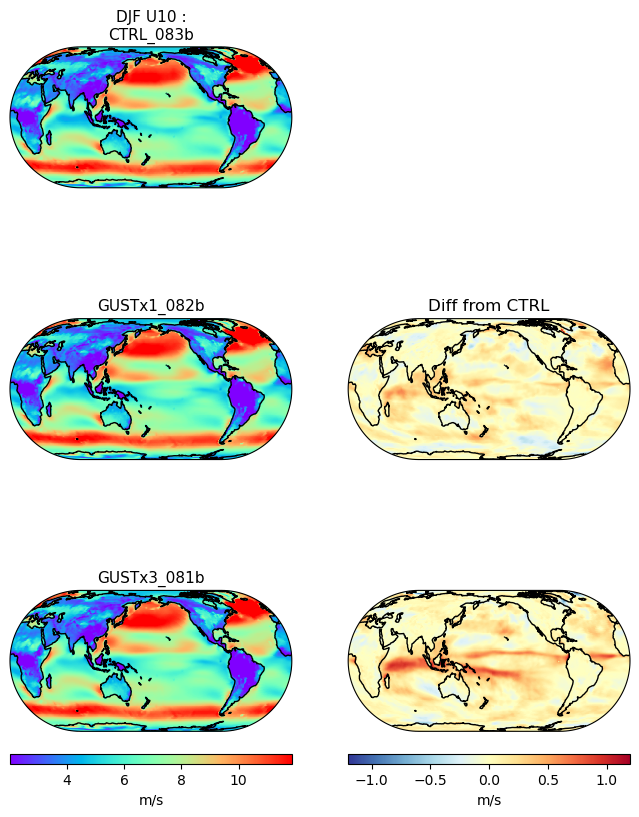

In [30]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
pltVar = 'U10' 
pltSeason = 'DJF'

axs = plotAllSims(DSsel, DSsel_seasons, pltVar, pltSeason, diffVal=1.2, unitStr='m/s')


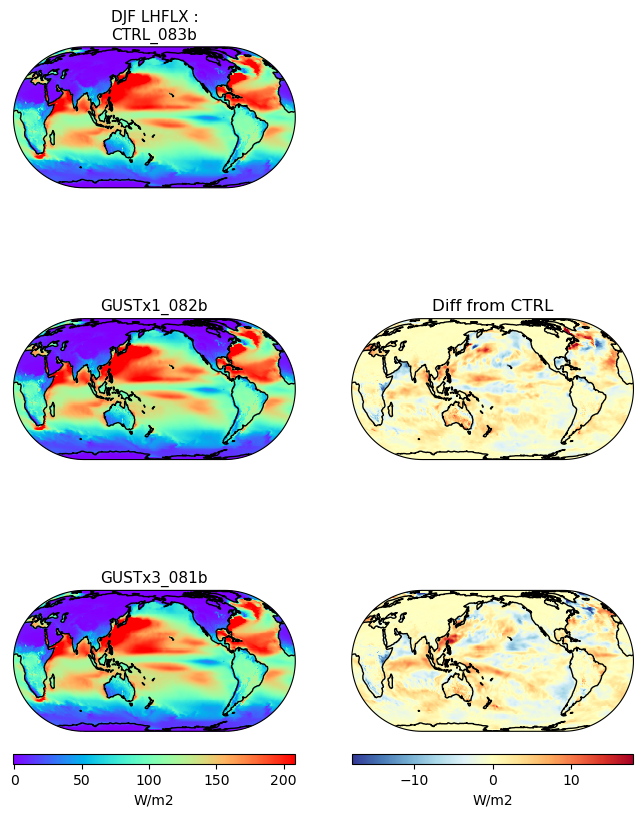

In [31]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
pltVar = 'LHFLX' 
pltSeason = 'DJF'

axs = plotAllSims(DSsel, DSsel_seasons, pltVar, pltSeason, diffVal = 18, unitStr=DSsel[pltVar].units)


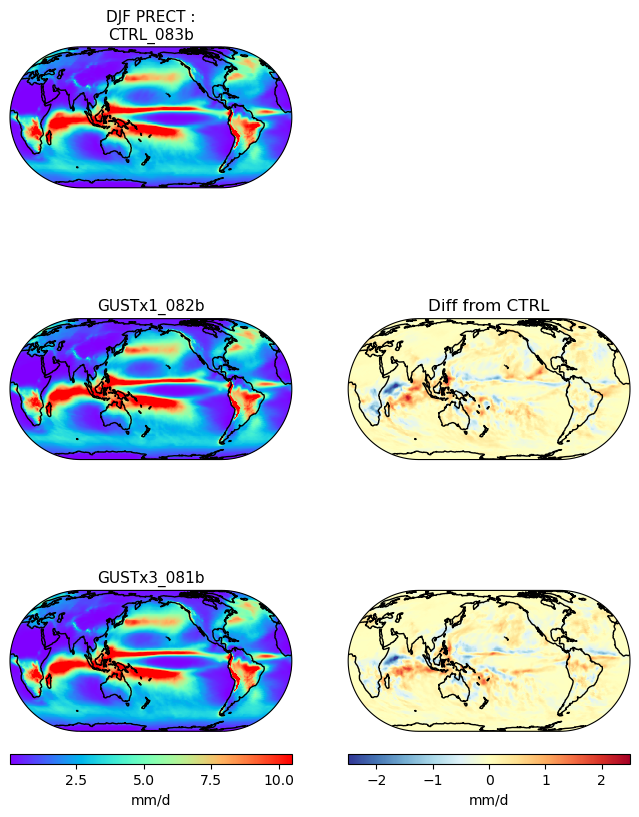

In [32]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
pltVar = 'PRECT' 
pltSeason = 'DJF'

axs = plotAllSims(DSsel, DSsel_seasons, pltVar, pltSeason, diffVal=2.5, varMult=86400 * 1e3, unitStr='mm/d')


In [33]:
def plotAllSims_bias(DS, DSseasonal, varName, obsVar, seasonSel='DJF', varMult = 1,
                pMinPct=2, pMaxPct = 98, pMin='Auto', pMax='Auto', diffVal='Auto', unitStr=''):
    if seasonSel=='ANN': 
        seasonMean = weighted_temporal_mean(DS, varName).mean(dim='time') * varMult
        obsData = weighted_temporal_mean(regridERA5, obsVar).mean(dim='time')
    else: 
        seasonMean = DSseasonal.sel(season=seasonSel)[varName] * varMult
        obsData = regridERA5_seasonal.sel(season=seasonSel)[obsVar]

    ## Figure out reasonable bounds for plot range 
    if pMin=='Auto':
        pMin = np.nanpercentile(seasonMean, pMinPct)
    if pMax=='Auto':
        pMax = np.nanpercentile(seasonMean, pMaxPct)
    var_norm = mpl.colors.Normalize(vmin=pMin, vmax=pMax)

    if diffVal=='Auto': 
        # diffs = seasonMean - seasonMean.isel(case=0)
        diffs = seasonMean - obsData
        diffVal = np.nanmax([np.abs(np.nanmax(diffs)), np.abs(np.nanmin(diffs))])*0.6
    diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)
        

    ## Make plot 
    fig, ax = plt.subplots(nrows=len(h0_drchFix.case.values), ncols=2, figsize=(8,10), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})
    ax = ax.ravel()
    
    for iInd in range(len(DS.case.values)):
        img1 = ax[(2*iInd)].pcolormesh(longrid, latgrid, seasonMean.isel(case=iInd).values* fillOcnFrac_h0_mean, 
                                   transform=ccrs.PlateCarree(), norm=var_norm, cmap='rainbow') 
        if iInd==0:
            ax[iInd].set_title(seasonSel+' '+varName+' :\n'+str(seasonMean.isel(case=iInd).case.values), fontsize=11)
        else:
            ax[(2*iInd)].set_title(str(seasonMean.isel(case=iInd).case.values), fontsize=11)

        ax[(2*iInd) + 1].pcolormesh(longrid, latgrid, 
                                      (seasonMean.isel(case=iInd).values - obsData.values)* fillOcnFrac_h0_mean, 
                                      transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')

        if iInd==len(DS.case.values)-1: 
            cax = ax[(2*iInd)].inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
            cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap="rainbow"),cax=cax,orientation="horizontal")
            cbar.ax.set_xlabel(unitStr)
            cbar.ax.locator_params(nbins=5)

            cax = ax[(2*iInd)+1].inset_axes([0, -0.23, 1, 0.07])  # THE NEW AXES, x, y, width, height,
            cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
            cbar.ax.set_xlabel(unitStr)
            # cbar.ax.locator_params(nbins=6)        
        
    ax[1].set_title('Diff from ERA5')
    # fig.delaxes(ax[1])
    
    [a.coastlines() for a in ax]
    [a.set_extent([1,358,-60,60],crs=ccrs.PlateCarree()) for a in ax]   ## Tropics


    return ax

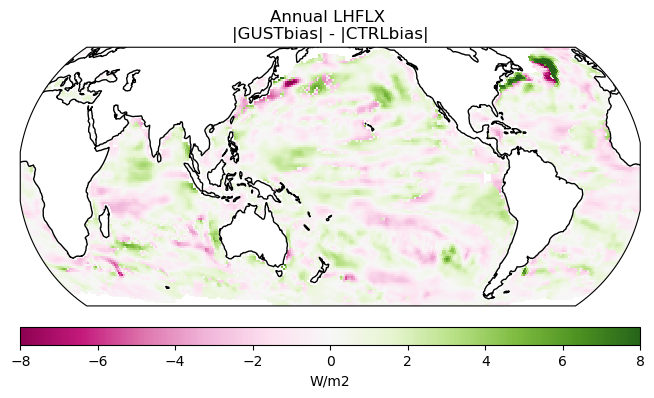

In [39]:
seasonMean = weighted_temporal_mean(h0_drchFix, 'LHFLX').mean(dim='time') 
obsData = weighted_temporal_mean(regridERA5, 'slhf').mean(dim='time')

biasCtrl =  (seasonMean.isel(case=0).values - obsData.values)* fillOcnFrac_h0_mean
biasGust =  (seasonMean.isel(case=1).values - obsData.values)* fillOcnFrac_h0_mean

diffVal=8
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)


fig, ax = plt.subplots(figsize=(8,10), subplot_kw={"projection":ccrs.EckertIV(central_longitude=180)})

ax.pcolormesh(longrid, latgrid, np.abs(biasGust) - np.abs(biasCtrl),
                              transform=ccrs.PlateCarree(), norm=diff_norm, cmap='PiYG')

cax = ax.inset_axes([0, -0.15, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="PiYG"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel('W/m2')
# cbar.ax.locator_params(nbins=6)
     
ax.set_title('Annual LHFLX \n|GUSTbias| - |CTRLbias|')

ax.coastlines() 
ax.set_extent([1,358,-60,60],crs=ccrs.PlateCarree()) 

plt.show()

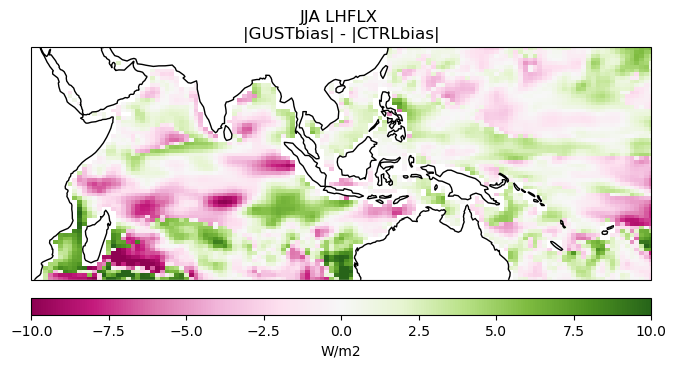

In [44]:
seasonMean = allH0_seasonal.sel(season='JJA').LHFLX
obsData    = regridERA5_seasonal.sel(season='JJA').slhf

biasCtrl =  (seasonMean.isel(case=0).values - obsData.values)* fillOcnFrac_h0_mean
biasGust =  (seasonMean.isel(case=1).values - obsData.values)* fillOcnFrac_h0_mean

diffVal=10
diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)


fig, ax = plt.subplots(figsize=(8,10), subplot_kw={"projection":ccrs.PlateCarree(central_longitude=180)})

ax.pcolormesh(longrid, latgrid, np.abs(biasGust) - np.abs(biasCtrl),
                              transform=ccrs.PlateCarree(), norm=diff_norm, cmap='PiYG')

cax = ax.inset_axes([0, -0.15, 1, 0.07])  # THE NEW AXES, x, y, width, height,
cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="PiYG"),cax=cax,orientation="horizontal")
cbar.ax.set_xlabel('W/m2')
# cbar.ax.locator_params(nbins=6)
     
ax.set_title('JJA LHFLX \n|GUSTbias| - |CTRLbias|')

ax.coastlines() 
# ax.set_extent([1,358,-60,60],crs=ccrs.PlateCarree()) 
ax.set_extent([30,190,-30,30],crs=ccrs.PlateCarree()) 

plt.show()

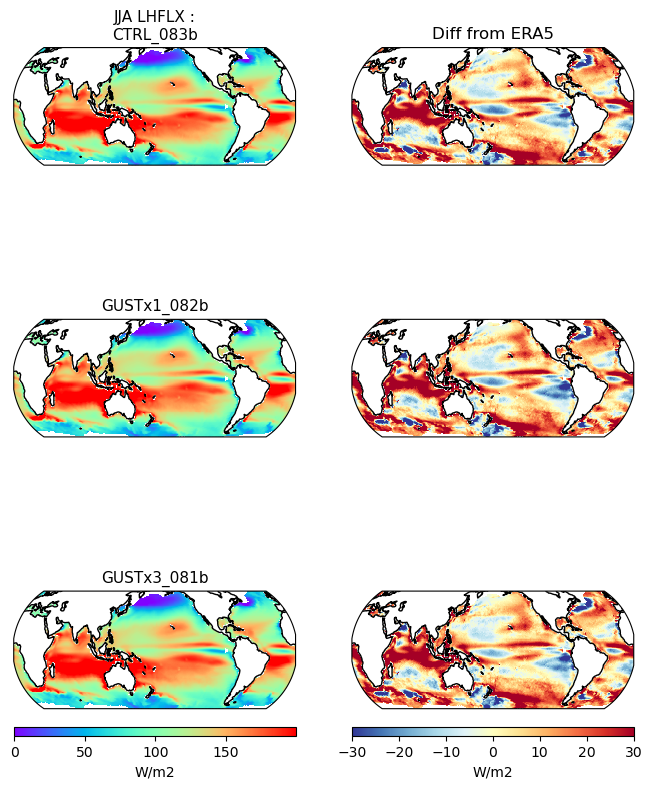

In [35]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
pltVar = 'LHFLX' 
pltSeason = 'JJA'
obsVar = 'slhf'

axs = plotAllSims_bias(DSsel, DSsel_seasons, pltVar, obsVar, pltSeason, diffVal = 30, unitStr=DSsel[pltVar].units)


#### More manuscript-ready

In [21]:
def plotBasicMaps(DS, DSseasonal, varList, cmapSel, seasonSel='DJF', varMult = 1,
                pMinPct=2, pMaxPct = 98, pMin='Auto', pMax='Auto', diffVal='Auto', unitStr=''):

    fig, ax = plt.subplots(ncols=len(DS.case.values), nrows=len(varList), figsize=(10,6),
                           subplot_kw={"projection":ccrs.PlateCarree(central_longitude=180)})
    ax = ax.ravel()
    
    for iVar in range(len(varList)):
        varName = varList[iVar]
        if ((varName=='PRECC') | (varName=='PRECT')):
            varMult = 86400 * 1e3
        else: 
            varMult = 1             
    
        if seasonSel=='ANN': ## Get weighted mean each year, then average over all years 
            seasonMean = weighted_temporal_mean(DS, varName).mean(dim='time') * varMult
            seasonMeanU10 = weighted_temporal_mean(DS, 'U10').mean(dim='time') 
        else: 
            seasonMean = DSseasonal.sel(season=seasonSel)[varName] * varMult
            seasonMeanU10 = DSseasonal.sel(season=seasonSel)['U10'] 
            
    
        ## Figure out reasonable bounds for plot range 
        if varName=='LHFLX': 
            pMinPct= 20
        else: 
            pMinPct = 2
            
        pMin = np.nanpercentile(seasonMean.values, pMinPct)
        pMax = np.nanpercentile(seasonMean.values, pMaxPct)    
        var_norm = mpl.colors.Normalize(vmin=pMin, vmax=pMax)
    
        diffs   = seasonMean - seasonMean.isel(case=0)
        diffVal = np.nanmax([np.abs(np.nanmax(diffs)), np.abs(np.nanmin(diffs))])*0.6
        diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

        ## Make plot  
        for iInd in range(len(DS.case.values)):
            if iInd==0: 
                img1 = ax[(iVar*3)+iInd].pcolormesh(longrid, latgrid, 
                                                fillOcnFrac_h0_mean*seasonMean.isel(case=iInd).values, 
                                                transform=ccrs.PlateCarree(), norm=var_norm, cmap=cmapSel[iVar]) 

            else: 
                img1 = ax[(iVar*3)+iInd].pcolormesh(longrid, latgrid, 
                                                fillOcnFrac_h0_mean * diffs.isel(case=iInd).values, 
                                                transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r') 

            # Add line contour
            CS = ax[(iVar*3)+iInd].contour(seasonMeanU10.lon.values, seasonMeanU10.lat.values, 
                    np.squeeze(seasonMeanU10.isel(case=0).values)*fillOcnFrac_h0_mean, [0, 6], 
                    colors='k',  transform=ccrs.PlateCarree())
            
            if ((iInd==0) & (iVar==0)):
                ax[(iVar*3)+iInd].set_title(seasonSel+' '+varName+' :\n'+str(seasonMean.isel(case=iInd).case.values), fontsize=11)
            elif ((iVar==0) & (iInd>0)):
                ax[(iVar*3)+iInd].set_title(str(seasonMean.isel(case=iInd).case.values)+' - CTRL', fontsize=11)
            elif ((iVar>0) & (iInd==0)):
                 ax[(iVar*3)+iInd].set_title(varName, fontsize=11)

            if iInd==0: 
                cax = ax[(iVar*3)+iInd].inset_axes([0, -0.23, 1, 0.12])  # THE NEW AXES, x, y, width, height,
                cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap=cmapSel[iVar]),cax=cax,orientation="horizontal")
                cbar.ax.set_xlabel(unitStr[iVar])
                cbar.ax.locator_params(nbins=4)
            elif iInd==1:
                cax = ax[(iVar*3)+iInd].inset_axes([0.25, -0.23, 1.5, 0.12])  # THE NEW AXES, x, y, width, height,
                cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
                cbar.ax.set_xlabel(unitStr[iVar])
                cbar.ax.locator_params(nbins=5)
                  
    [a.coastlines() for a in ax]
    [a.set_extent([30,190,-30,30], crs=ccrs.PlateCarree()) for a in ax]

    return ax

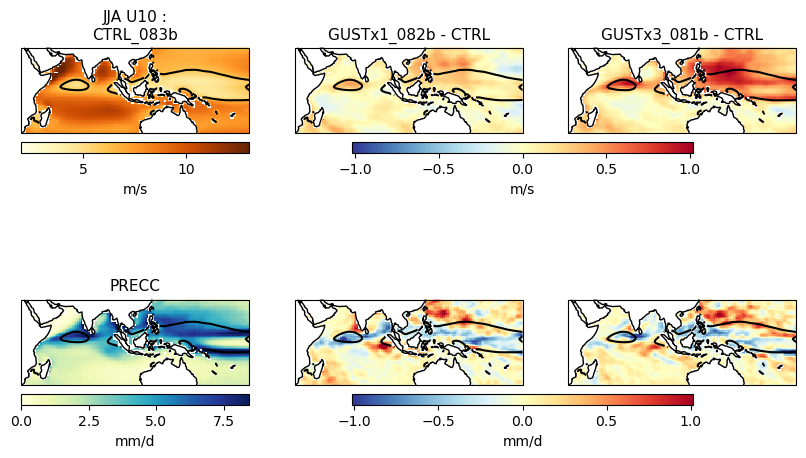

In [26]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
varList = ['U10','PRECC',]
cmapSel = ['YlOrBr','YlGnBu']
pltSeason = 'JJA'

axs = plotBasicMaps(DSsel, DSsel_seasons, varList, cmapSel, pltSeason, pMaxPct=99, 
                    unitStr=['m/s','mm/d'])


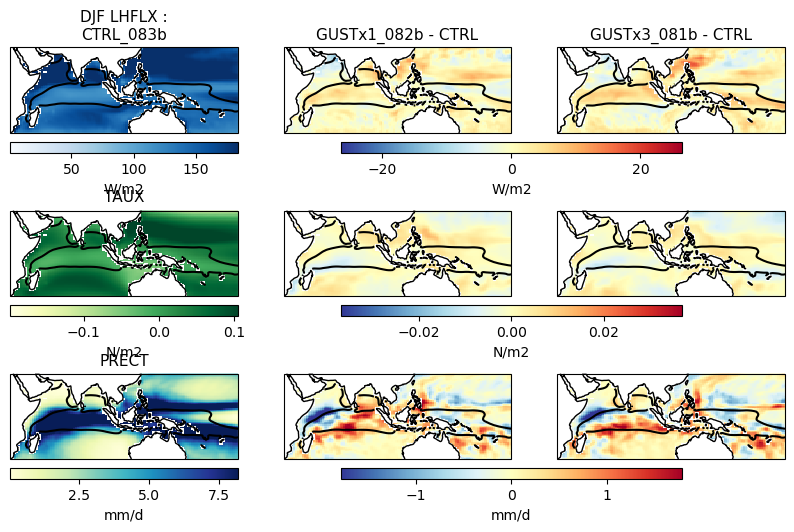

In [23]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
varList = ['LHFLX','TAUX','PRECT']
cmapSel = ['Blues','YlGn','YlGnBu']
pltSeason = 'DJF'

axs = plotBasicMaps(DSsel, DSsel_seasons, varList, cmapSel, pltSeason, pMaxPct=95, 
                    unitStr=['W/m2', DSsel.TAUX.units, 'mm/d'])


In [29]:
def plotBasicMaps_bias(DS, DSseasonal, DSvar,  obsVar, cmapSel, 
                       seasonSel='DJF', varMult = 1, pMinPct=2, pMaxPct = 98, 
                       pMin='Auto', pMax='Auto', diffVal='Auto', unitStr=''):

    fig, ax = plt.subplots(ncols=len(DS.case.values), nrows=2, figsize=(12,5),
                           subplot_kw={"projection":ccrs.PlateCarree(central_longitude=180)})
    ax = ax.ravel()
    
    for iVar in range(len(varList)):
        varName = varList
        if ((varName=='PRECC') | (varName=='PRECT')):
            varMult = 86400 * 1e3
        else: 
            varMult = 1             
    
        if seasonSel=='ANN': ## Get weighted mean each year, then average over all years 
            seasonMean = weighted_temporal_mean(DS, varName).mean(dim='time') * varMult
            seasonMeanU10 = weighted_temporal_mean(DS, 'U10').mean(dim='time') 
            obsData = weighted_temporal_mean(regridERA5, obsVar).mean(dim='time')
        else: 
            seasonMean = DSseasonal.sel(season=seasonSel)[varName] * varMult
            seasonMeanU10 = DSseasonal.sel(season=seasonSel)['U10'] 
            obsData    = regridERA5_seasonal.sel(season=seasonSel)[obsVar]
            
    
        ## Figure out reasonable bounds for plot range 
        if varName=='LHFLX': 
            pMinPct= 20
        else: 
            pMinPct = 2
            
        pMin = np.nanpercentile(seasonMean.values, pMinPct)
        pMax = np.nanpercentile(seasonMean.values, pMaxPct)    
        var_norm = mpl.colors.Normalize(vmin=pMin, vmax=pMax)
    
        diffs   = seasonMean - seasonMean.isel(case=0)
        diffVal = np.nanmax([np.abs(np.nanmax(diffs)), np.abs(np.nanmin(diffs))])*0.4
        diff_norm = mpl.colors.Normalize(vmin=-diffVal, vmax=diffVal)

        bias = seasonMean - obsData
        biasVal = np.nanmax([np.abs(np.nanmax(bias)), np.abs(np.nanmin(bias))])*0.4
        bias_norm = mpl.colors.Normalize(vmin=-biasVal, vmax=biasVal) 

        biasDiff = np.abs(bias) - np.abs(bias.isel(case=0))
        biasDiffVal = np.nanmax([np.abs(np.nanmax(biasDiff)), np.abs(np.nanmin(biasDiff))])*0.4
        biasDiff_norm = mpl.colors.Normalize(vmin=-biasDiffVal, vmax=biasDiffVal) 

        ## Make plot  
        for iInd in range(len(DS.case.values)):
            if iInd==0: 
                img1 = ax[iInd].pcolormesh(longrid, latgrid, 
                                                fillOcnFrac_h0_mean*seasonMean.isel(case=iInd).values, 
                                                transform=ccrs.PlateCarree(), norm=var_norm, cmap=cmapSel) 
                img2 = ax[3+iInd].pcolormesh(longrid, latgrid, 
                                                fillOcnFrac_h0_mean*bias.isel(case=0).values, 
                                                transform=ccrs.PlateCarree(), norm=bias_norm, cmap='seismic') 

            else: 
                img1 = ax[iInd].pcolormesh(longrid, latgrid, 
                                                fillOcnFrac_h0_mean * diffs.isel(case=iInd).values, 
                                                transform=ccrs.PlateCarree(), norm=diff_norm, cmap='RdYlBu_r')
                img2 = ax[3+iInd].pcolormesh(longrid, latgrid, 
                                                fillOcnFrac_h0_mean * biasDiff.isel(case=iInd).values, 
                                                transform=ccrs.PlateCarree(), norm=biasDiff_norm, cmap='PRGn') 

            # Add line contour
            # CS = ax[(iVar*3)+iInd].contour(seasonMeanU10.lon.values, seasonMeanU10.lat.values, 
            #         np.squeeze(seasonMeanU10.isel(case=0).values)*fillOcnFrac_h0_mean, [0, 6], 
            #         colors='k',  transform=ccrs.PlateCarree())
            
            if ((iInd==0) ):
                ax[iInd].set_title(seasonSel+' '+varName+' :\n'+str(seasonMean.isel(case=iInd).case.values), fontsize=11)
                ax[3+iInd].set_title(seasonSel+' '+varName+' :\n'+str(seasonMean.isel(case=iInd).case.values)+' Bias', fontsize=11)
            else: 
                ax[iInd].set_title(str(seasonMean.isel(case=iInd).case.values)+' - CTRL', fontsize=11)
                ax[3+iInd].set_title('|'+str(seasonMean.isel(case=iInd).case.values)+' bias| - |CTRL bias|', fontsize=11)


            if iInd==0: 
                cax = ax[iInd].inset_axes([0, -0.23, 1, 0.12])  # THE NEW AXES, x, y, width, height,
                cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=var_norm, cmap=cmapSel),cax=cax,orientation="horizontal")
                cbar.ax.set_xlabel(unitStr)
                # cbar.ax.locator_params(nbins=4)

                cax = ax[3+iInd].inset_axes([0, -0.23, 1, 0.12])  # THE NEW AXES, x, y, width, height,
                cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=bias_norm, cmap='seismic'),cax=cax,orientation="horizontal")
                cbar.ax.set_xlabel(unitStr)
                # cbar.ax.locator_params(nbins=4)

            
            elif iInd==1:
                cax = ax[iInd].inset_axes([0.25, -0.23, 1.5, 0.12])  # THE NEW AXES, x, y, width, height,
                cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=diff_norm, cmap="RdYlBu_r"),cax=cax,orientation="horizontal")
                cbar.ax.set_xlabel(unitStr)
                # cbar.ax.locator_params(nbins=5)

                cax = ax[3+iInd].inset_axes([0.25, -0.23, 1.5, 0.12])  # THE NEW AXES, x, y, width, height,
                cbar = fig.colorbar(matplotlib.cm.ScalarMappable(norm=biasDiff_norm, cmap="PRGn"),cax=cax,orientation="horizontal")
                cbar.ax.set_xlabel(unitStr)
                # cbar.ax.locator_params(nbins=5)
                  
    [a.coastlines() for a in ax]
    [a.set_extent([30,190,-30,30], crs=ccrs.PlateCarree()) for a in ax]

    return ax

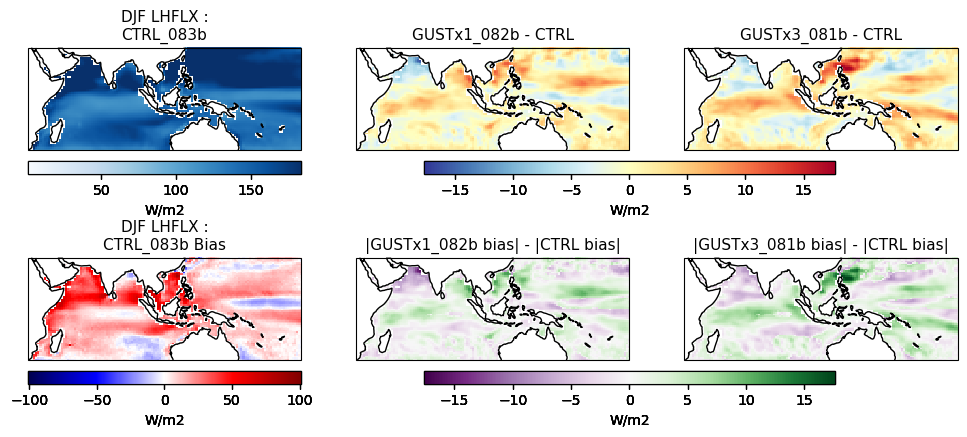

In [30]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
eraVar = 'slhf'
varList = 'LHFLX'
cmapSel = 'Blues'
pltSeason = 'DJF'

axs = plotBasicMaps_bias(DSsel, DSsel_seasons, varList, eraVar, cmapSel, pltSeason, pMaxPct=95, 
                    unitStr='W/m2')


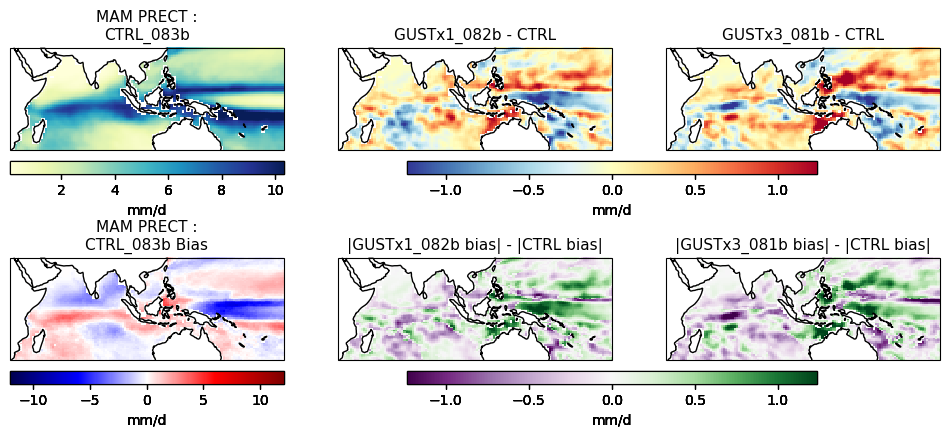

In [33]:
DSsel = h0_drchFix
DSsel_seasons = allH0_seasonal
eraVar = 'tp'
varList = 'PRECT'
cmapSel = 'YlGnBu'
pltSeason = 'MAM'

axs = plotBasicMaps_bias(DSsel, DSsel_seasons, varList, eraVar, cmapSel, pltSeason, pMaxPct=99, 
                    unitStr='mm/d')


#### Distributions?

In [ ]:
def plotDistribution(minLat,maxLat,minLon,maxLon, regionTitle, 
                     DS_h1, DS_h0, varName, unitsString,
                     DS_obs, obsVarName,
                     season='DJF', timeFreq='monthly',
                     valueMultiplier=1, varMin=None, varMax=None, 
                     ):
    
    ## - - - - - - - - - - - - - - - - - 
    ## Select data     
    ## - - - - - - - - - - - - - - - - - 
    # Get season
    if season=='JJA':
        monStart=6
        monEnd=8
        iTime_h1 = np.where( (DS_h1['time.month']>=monStart) & (DS_h1['time.month']<=monEnd) )[0]
        iTime_h0 = np.where( (DS_h0['time.month']>=monStart) & (DS_h0['time.month']<=monEnd) )[0]
        iTime_obs = np.where( (DS_obs['time.month']>=monStart) & (DS_obs['time.month']<=monEnd) )[0]
    elif season=='DJF':
        iTime_h1 = np.where( (DS_h1['time.month']==12) | (DS_h1['time.month']<=2) )[0]
        iTime_h0 = np.where( (DS_h0['time.month']==12) | (DS_h0['time.month']<=2) )[0]
        iTime_obs = np.where( (DS_obs['time.month']==12) | (DS_obs['time.month']<=2) )[0]
    
    # Get lat and lon too
    iLat  = np.where( (DS_h0['lat']>=minLat) & (DS_h0['lat']<=maxLat) )[0]
    iLon  = np.where( (DS_h0['lon']>=minLon) & (DS_h0['lon']<=maxLon) )[0]
    
     
    
    if timeFreq=='daily': 
        mainDS = DS_h1.isel(time=iTime_h1, lat=iLat, lon=iLon)
    elif timeFreq=='monthly':
        mainDS = DS_h0.isel(time=iTime_h0, lat=iLat, lon=iLon)

    # ALSO: Take only 10 years for obs...
    selObs = DS_obs.isel(time=iTime_obs, lat=iLat, lon=iLon).isel(time=np.arange(1,31))

    ## Get ocean mask 
    fillOcnFrac = np.full([len(mainDS.case.values), len(mainDS.time.values), len(mainDS.lat.values), len(mainDS.lon.values)], np.nan)
    fillOcnFrac[:,:,:,:] = DS_h0.isel(time=iTime_h0, lat=iLat, lon=iLon).OCNFRAC.isel(case=0, time=12)
    fillOcnFrac[np.where(fillOcnFrac!=1)] = np.nan

    ## - - - - - - - - - - - - - - - - - 
    ## Plot the distribution 
    ## - - - - - - - - - - - - - - - - - 

    oceanVar = mainDS[varName]* valueMultiplier * fillOcnFrac

    obsVar = selObs[obsVarName] * fillOcnFrac[0,0:len(selObs.time.values),:,:]

    if varMin: 
        oceanVar   = oceanVar.where(oceanVar>varMin)
        obsVar     = obsVar.where(obsVar>varMin)

    if varMax: 
        oceanVar   = oceanVar.where(oceanVar<varMax)
        obsVar     = obsVar.where(obsVar<varMax)


    numEl = len(oceanVar.lat.values)*len(oceanVar.lon.values)*len(oceanVar.time.values)  
    numEl_obs = len(obsVar.lat.values)*len(obsVar.lon.values)*len(obsVar.time.values)

    
    dfReal = pd.concat(axis=0, ignore_index=True, objs=[
             pd.DataFrame.from_dict({varName: np.squeeze(oceanVar.isel(case=0).values.reshape(numEl,1)), 'case': str(oceanVar.isel(case=0).case.values)}),
             pd.DataFrame.from_dict({varName: np.squeeze(oceanVar.isel(case=1).values.reshape(numEl,1)), 'case': str(oceanVar.isel(case=1).case.values)}),
             pd.DataFrame.from_dict({varName: np.squeeze(oceanVar.isel(case=2).values.reshape(numEl,1)), 'case': str(oceanVar.isel(case=2).case.values)}),
             # pd.DataFrame.from_dict({varName: np.squeeze(oceanVar.isel(case=3).values.reshape(numEl,1)), 'case': str(oceanVar.isel(case=3).case.values)}),
             pd.DataFrame.from_dict({varName: np.squeeze(obsVar.values.reshape(numEl_obs,1)), 'case': 'ERA5'}),
             ])

    # Make plot 
    g = sns.displot(dfReal, x=varName, hue='case', kind='kde', height=6, cut=0, aspect=1,
                    log_scale=False, common_norm = False, alpha=0.7,
                     # palette=['grey','deepskyblue','blue','purple','deeppink'])
                     palette=['black','orangered','maroon','blue'])

    g.ax.set_xlabel(unitsString,fontsize=16)
    g.ax.set_ylabel('Probability Density',fontsize=16)
    g.ax.tick_params(axis='both', labelsize= 14)
    # g.ax.set_title(season+' '+regionTitle+' '+timeFreq+' '+varName+' (No avg in time/space)',fontsize=16)
    g.ax.set_title(season+' '+regionTitle+' '+timeFreq+' '+varName, fontsize=16)
    plt.setp(g._legend.get_title(), fontsize=14)
    plt.setp(g._legend.get_texts(), fontsize=14)

    
    return

In [ ]:
plotDistribution(-15,15,0,360, 'Tropics (15˚S - 15˚N)', 
                     h1_drchFix, h0_drchFix, 'LHFLX', 
                     'W/m**2',
                     regridERA5,'slhf', 
                     season='JJA', timeFreq='monthly',
                     valueMultiplier=1, varMin=0, varMax=300,
                     )


In [ ]:
plotDistribution(-15,15,0,360, 'Tropics (15˚S - 15˚N)', 
                     h1_drchFix, h0_drchFix,  'PRECT', 
                     'mm/d',
                     regridERA5,'tp', 
                     season='JJA', timeFreq='monthly',
                     valueMultiplier=86400*1e3, varMin=0.029, varMax=15,
                     )


In [ ]:
plotDistribution(-15,15,40,105, 'Eq. IO', 
                     h1_drchFix, h0_drchFix, 'U10', 
                     'm/s',
                     regridERA5,'U10', 
                     season='DJF', timeFreq='daily',
                     valueMultiplier=1, varMin=None, varMax=15,
                     )


In [ ]:
plotDistribution(-15,15,0,360, 'Tropics (15˚S - 15˚N)', 
                     h1_drchFix, h0_drchFix, 'LHFLX', 
                     'W/m**2',
                     regridERA5,'slhf', 
                     season='JJA', timeFreq='daily',
                     valueMultiplier=1, varMin=0, varMax=300,
                     )


#### Walker Circulation?

In [27]:
h0_drchFix.OMEGA.units

'Pa/s'

In [21]:
all_h0_DJF           = allH0_seasonal.sel(season='DJF')


In [23]:
## Also read in the 3D ERA5 OMEGA field 
filePath = '/glade/work/mdfowler/obs/ERA5_omega.nc'
era5_omega = xr.open_dataset(filePath, decode_times=True)

era5_omega = era5_omega.reindex(latitude=era5_omega.latitude[::-1])
era5_omega = era5_omega.rename_dims(dims_dict={'latitude':'lat', 'longitude':'lon'})
era5_omega = era5_omega.rename(name_dict={'latitude':'lat', 'longitude':'lon'})

## Convert longitude to be 0 to 360, not -180 to 180 (not an issue above that I can tell)
era5_omega.coords['lon'] = (era5_omega.coords['lon'] + 360) % 360 
era5_omega = era5_omega.sortby(era5_omega.lon)

regridERA5_omega = regrid_data(era5_omega, camGrid, method=1)

# iTimes_DJF = np.where( (regridERA5_omega['time.month']==12) | (regridERA5_omega['time.month']<=2) )[0]
# regridERA5_omega_DJF = regridERA5_omega.isel(time=iTimes_DJF).mean(dim='time')

## Get seasonal means of ERA5 data too 
month_length = regridERA5_omega.time.dt.days_in_month

# Calculate the weights by grouping by 'time.season'.
weights = (month_length.groupby("time.season") / month_length.groupby("time.season").sum())

# Calculate the weighted average
regridERA5_omega_seasonal = (regridERA5_omega * weights).groupby("time.season").sum(dim="time")
regridERA5_omega_DJF = regridERA5_omega_seasonal.sel(season='DJF') 


In [19]:
## Take a look at Walker Circulation?
fillOcnFrac_h0_withLevs = np.full([len(all_h0_DJF.case.values), len(all_h0_DJF.lev.values), 
                                   len(all_h0_DJF.lat.values), len(all_h0_DJF.lon.values)], 
                                   np.nan)

for ilev in range(len(all_h0_DJF.lev.values)):
    fillOcnFrac_h0_withLevs[:,ilev,:,:] = fillOcnFrac_h0_mean
    

ilat         = np.where((all_h0_DJF.lat.values>=-5) & (all_h0_DJF.lat.values<=5))[0]

walkerRegion_OMEGA = (fillOcnFrac_h0_withLevs*all_h0_DJF['OMEGA']).isel(lat=ilat).mean(dim='lat')
walkerRegion_U     = (fillOcnFrac_h0_withLevs*all_h0_DJF['U']).isel(lat=ilat).mean(dim='lat')


In [24]:
fillOcnFrac_h0_withLevsERA5 = np.full([len(regridERA5_omega_DJF.level.values), 
                                       len(regridERA5_omega_DJF.lat.values), 
                                       len(regridERA5_omega_DJF.lon.values)], 
                                       np.nan)
for ilev in range(len(regridERA5_omega_DJF.level.values)):
    fillOcnFrac_h0_withLevsERA5[ilev,:,:] = fillOcnFrac_h0_mean[:,:]
    
ERA5_walkerRegion_OMEGA = (fillOcnFrac_h0_withLevsERA5*regridERA5_omega_DJF['w']).isel(lat=ilat).mean(dim='lat')
ERA5_walkerRegion_U     = (fillOcnFrac_h0_withLevsERA5*regridERA5_omega_DJF['u']).isel(lat=ilat).mean(dim='lat')



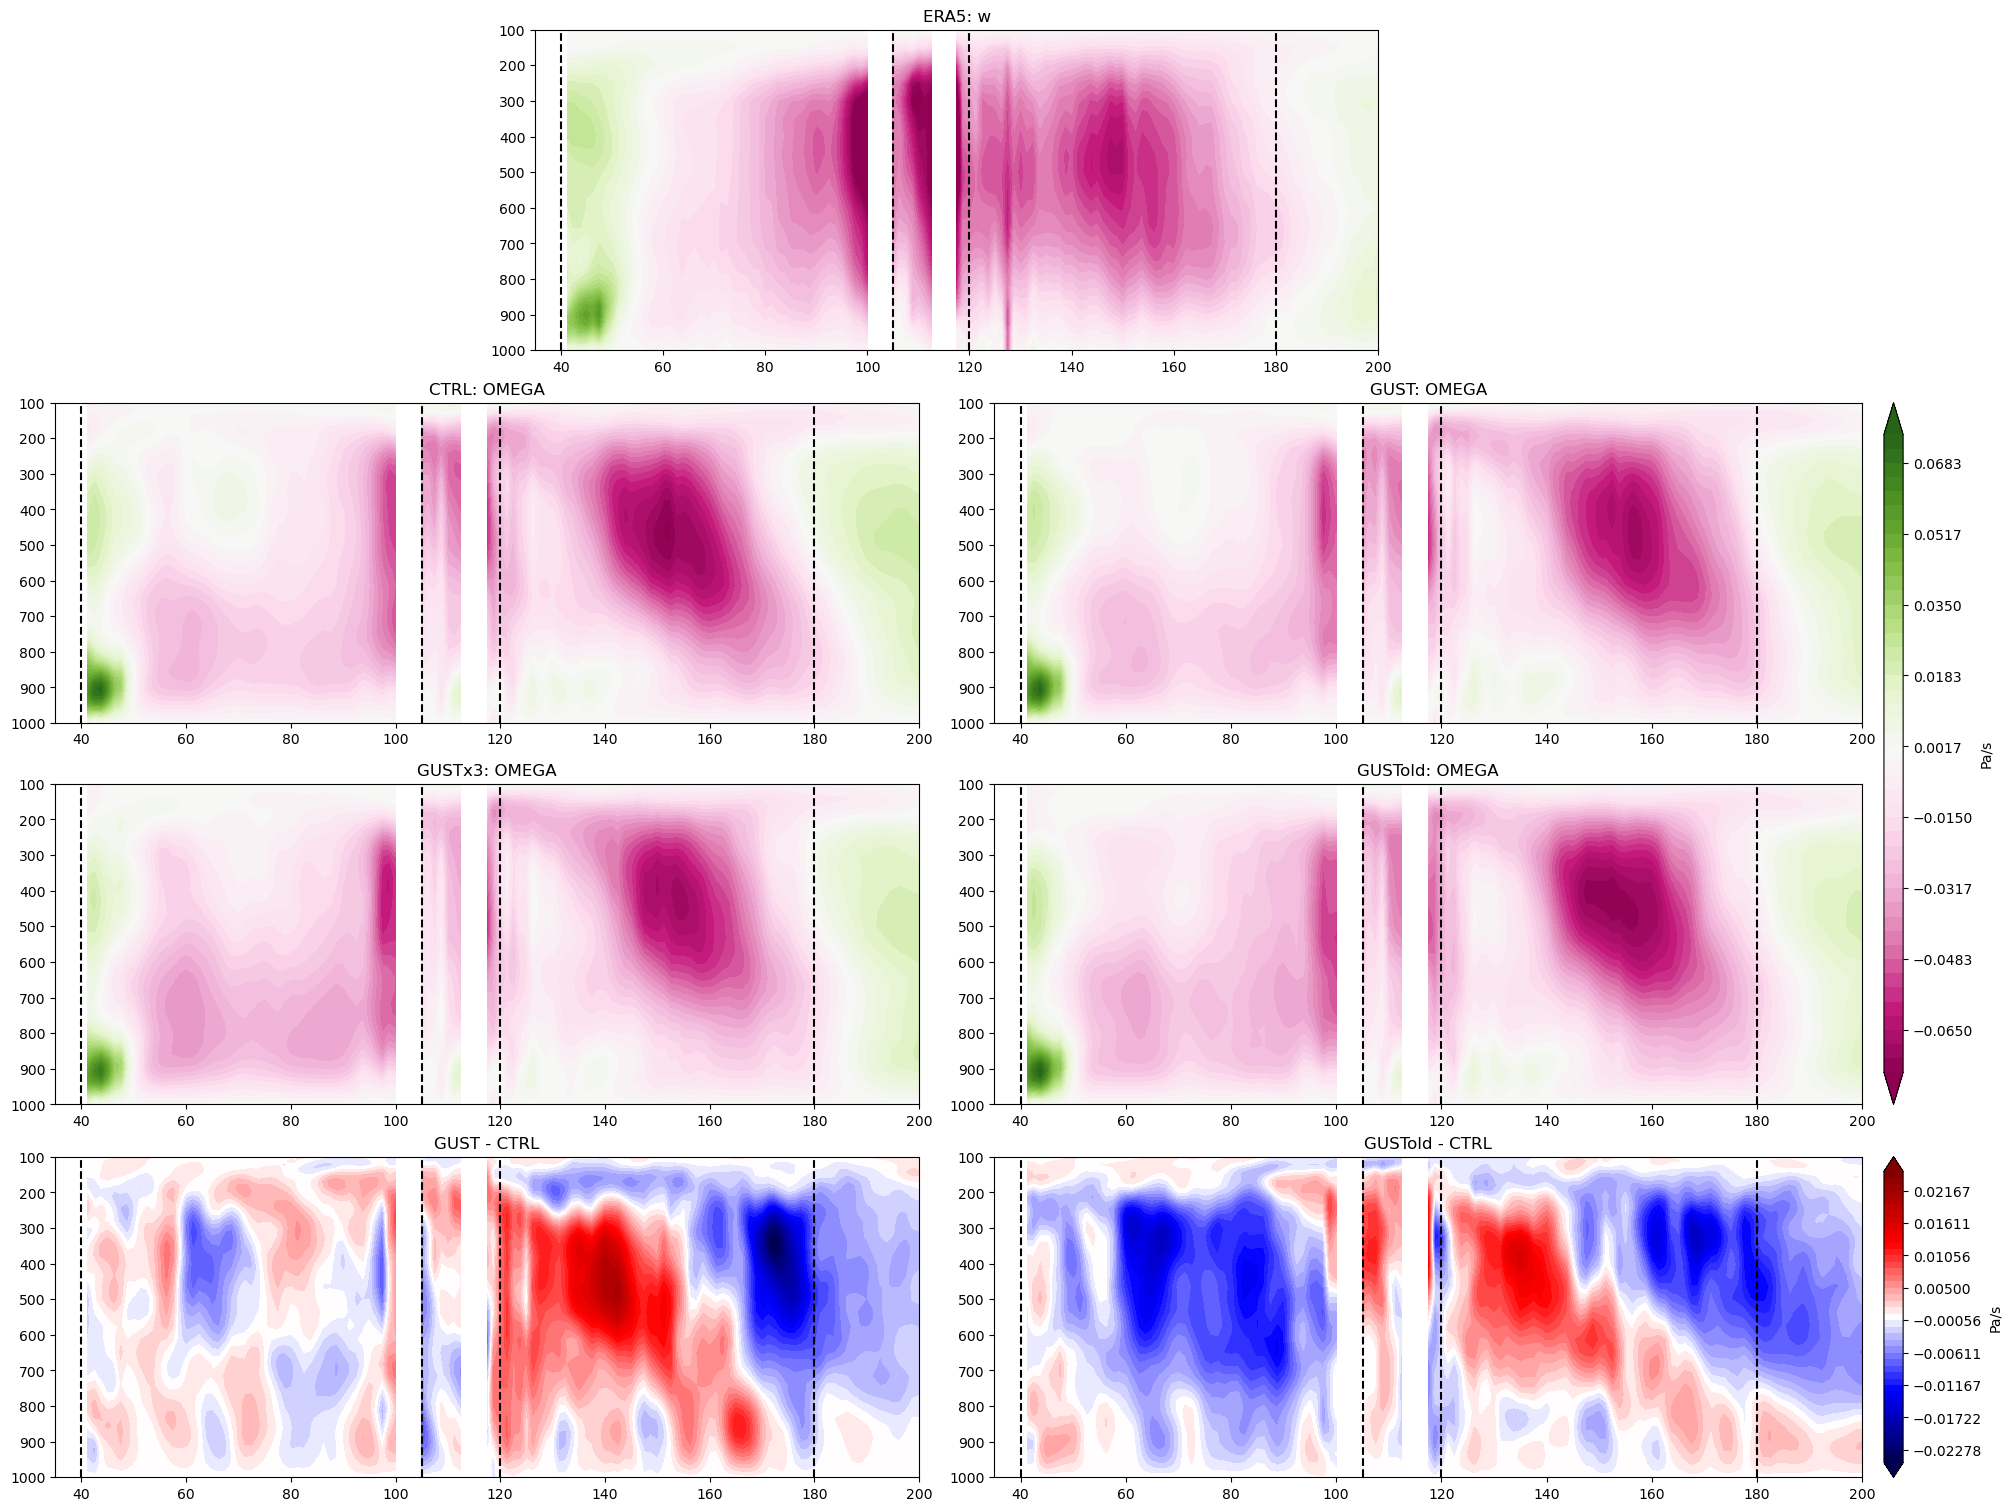

In [33]:
fig3 = plt.figure(constrained_layout=True, figsize=(20,15))
gs = fig3.add_gridspec(4, 5, width_ratios=[1,1,1,1,0.05])

# fig, axs = plt.subplots(3,2, figsize=(20,15))
# axs      = axs.ravel()

DStoUse     = walkerRegion_OMEGA
nstepLevs = (0.75e-1*2)/45
nstepDiffs = (2*2.5e-2)/45
levsMap     = np.arange(-0.75e-1, 0.75e-1+nstepLevs, nstepLevs) ## OMEGA500
diffLevs    = np.arange(-2.5e-2, 2.5e-2+nstepDiffs, nstepDiffs)  ## OMEGA500
unitsString = h0_drchFix.OMEGA.units
varSel = 'OMEGA'

# DStoUse     = walkerRegion_U
# levsMap     = np.arange(-11, 11.1, 0.1) ## OMEGA500
# diffLevs    = np.arange(-6,   6.1, 0.1)  ## OMEGA500
# unitsString = all_h0['U'].units
# varSel      = 'U'


axs0 = fig3.add_subplot(gs[0, 1:3])
axs0.contourf(ERA5_walkerRegion_OMEGA.lon.values, ERA5_walkerRegion_OMEGA.level.values, ERA5_walkerRegion_OMEGA.values,
               levsMap, cmap='PiYG', extend='both')
axs0.invert_yaxis()
axs0.axvline(40,color='k',linestyle='--')
axs0.axvline(105,color='k',linestyle='--')
axs0.axvline(120,color='k',linestyle='--')
axs0.axvline(180,color='k',linestyle='--')
axs0.set_title('ERA5: w')
axs0.set_ylim([1000,100])
axs0.set_xlim([35,200])

axs1 = fig3.add_subplot(gs[1, 0:2])
axs1.contourf(DStoUse.lon.values, DStoUse.lev.values, DStoUse.isel(case=0).values,
               levsMap, cmap='PiYG', extend='both')
axs1.invert_yaxis()
axs1.axvline(40,color='k',linestyle='--')
axs1.axvline(105,color='k',linestyle='--')
axs1.axvline(120,color='k',linestyle='--')
axs1.axvline(180,color='k',linestyle='--')
axs1.set_title(str(DStoUse.isel(case=0).case.values)+': '+varSel)
axs1.set_ylim([1000,100])
axs1.set_xlim([35,200])

axs2 = fig3.add_subplot(gs[1, 2:4])
axs2.contourf(DStoUse.lon.values, DStoUse.lev.values, DStoUse.isel(case=1).values,
               levsMap, cmap='PiYG', extend='both')
axs2.invert_yaxis()
axs2.axvline(40,color='k',linestyle='--')
axs2.axvline(105,color='k',linestyle='--')
axs2.axvline(120,color='k',linestyle='--')
axs2.axvline(180,color='k',linestyle='--')
axs2.set_title(str(DStoUse.isel(case=1).case.values)+': '+varSel)
axs2.set_ylim([1000,100])
axs2.set_xlim([35,200])

axs3 = fig3.add_subplot(gs[2, 0:2])
axs3.contourf(DStoUse.lon.values, DStoUse.lev.values, DStoUse.isel(case=2).values,
               levsMap, cmap='PiYG', extend='both')
axs3.invert_yaxis()
axs3.axvline(40,color='k',linestyle='--')
axs3.axvline(105,color='k',linestyle='--')
axs3.axvline(120,color='k',linestyle='--')
axs3.axvline(180,color='k',linestyle='--')
axs3.set_title(str(DStoUse.isel(case=2).case.values)+': '+varSel)
axs3.set_ylim([1000,100])
axs3.set_xlim([35,200])

axs4 = fig3.add_subplot(gs[2, 2:4])
cplt = axs4.contourf(DStoUse.lon.values, DStoUse.lev.values, DStoUse.isel(case=3).values,
               levsMap, cmap='PiYG', extend='both')
axs4.invert_yaxis()
axs4.axvline(40,color='k',linestyle='--')
axs4.axvline(105,color='k',linestyle='--')
axs4.axvline(120,color='k',linestyle='--')
axs4.axvline(180,color='k',linestyle='--')
axs4.set_ylim([1000,100])
axs4.set_xlim([35,200])
axs4.set_title(str(DStoUse.isel(case=3).case.values)+': '+varSel)
# Add colorbar
# ax_position = axs4.get_position()
# cbar_ax     = fig.add_axes([ax_position.x0-0.24, ax_position.y0-0.02, ax_position.width+0.1, 0.015])
# cbar        = plt.colorbar(cplt, orientation='horizontal',cax=cbar_ax)
# cbar.set_label(unitsString,fontsize=11)

# PLOT: COLORBAR                                                                                                                     
axes = fig3.add_subplot(gs[1:3,4])
plt.colorbar(cplt, cax=axes, label='Pa/s')



## Plot diffs 
diff1= DStoUse.isel(case=1).values - DStoUse.isel(case=0).values
diff2 = DStoUse.isel(case=3).values - DStoUse.isel(case=0).values
    
axs5 = fig3.add_subplot(gs[3, 0:2])
axs5.contourf(DStoUse.lon.values, DStoUse.lev.values, diff1, 
                                diffLevs,
                                cmap='seismic',extend='both',
                                # cmap='Purples',extend='both',
                                )
axs5.set_title(str(DStoUse.isel(case=1).case.values)+' - CTRL')
axs5.axvline(40,color='k',linestyle='--')
axs5.axvline(105,color='k',linestyle='--')
axs5.axvline(120,color='k',linestyle='--')
axs5.axvline(180,color='k',linestyle='--')
axs5.set_ylim([1000,100])
axs5.set_xlim([35,200])

axs6 = fig3.add_subplot(gs[3, 2:4])
cplt = axs6.contourf(DStoUse.lon.values, DStoUse.lev.values, diff2, 
                                diffLevs,
                                cmap='seismic',extend='both',
                                # cmap='Purples',extend='both',
                                )
axs6.axvline(40,color='k',linestyle='--')
axs6.axvline(105,color='k',linestyle='--')
axs6.axvline(120,color='k',linestyle='--')
axs6.axvline(180,color='k',linestyle='--')
axs6.set_ylim([1000,100])
axs6.set_xlim([35,200])
axs6.set_title(str(DStoUse.isel(case=3).case.values)+' - CTRL')

# PLOT: COLORBAR                                                                                                                     
axes = fig3.add_subplot(gs[3,4])
plt.colorbar(cplt, cax=axes, label='Pa/s')

